## 0. Import Packages and Set Hyperparameters

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image, HTML
import matplotlib.animation as animation

In [2]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 50

## 1. Load Datasets (MNIST)

In [3]:
mnist_train = dset.MNIST(
    "./",
    train=True,
    transform=transforms.ToTensor(),
    target_transform=None,
    download=True,
)
mnist_test = dset.MNIST(
    "./",
    train=False,
    transform=transforms.ToTensor(),
    target_transform=None,
    download=True,
)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

In [4]:
dataloaders = {}
dataloaders["train"] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders["val"] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders["test"] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

## 2. Define VAE Model and Optimizer

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU()
        )

        self.fc_mu = nn.Linear(256, 10)
        self.fc_var = nn.Linear(256, 10)

        self.decoder = nn.Sequential(
            nn.Linear(10, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        recon = self.decoder(z)
        return recon

    def forward(self, x):
        batch_size = x.size(0)
        mu, log_var = self.encode(x.view(batch_size, -1))
        z = self.reparameterize(mu, log_var)
        out = self.decode(z)
        return out, mu, log_var

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
BCE = torch.nn.BCELoss(reduction="sum")


def loss_func(x, recon_x, mu, log_var):
    BCE_loss = BCE(recon_x, x.view(-1, 28 * 28))
    KLD_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE_loss + KLD_loss

In [8]:
model = VariationalAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 3. Training

In [9]:
import time
import copy


def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # transfer inputs to GPU

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):

                    outputs, mu, log_var = model(inputs)
                    loss = criterion(inputs, outputs, mu, log_var)  # calculate a loss

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()  # perform back-propagation from the loss
                        optimizer.step()  # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print("{} Loss: {:.4f}".format(phase, epoch_loss))

            # deep copy the model
            if phase == "train":
                train_loss_history.append(epoch_loss)

            if phase == "val":
                val_loss_history.append(epoch_loss)

            if phase == "val" and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Loss: {:4f}".format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [20]:
best_model, train_loss_history, val_loss_history = train_model(
    model, dataloaders, loss_func, optimizer, num_epochs=num_epochs
)

Epoch 0/49
----------
train Loss: 99.5125
val Loss: 101.3827

Epoch 1/49
----------
train Loss: 99.3986
val Loss: 101.1568

Epoch 2/49
----------
train Loss: 99.2577
val Loss: 101.4348

Epoch 3/49
----------
train Loss: 99.0771
val Loss: 101.2534

Epoch 4/49
----------
train Loss: 98.9933
val Loss: 101.4684

Epoch 5/49
----------
train Loss: 98.9298
val Loss: 100.9944

Epoch 6/49
----------
train Loss: 98.8373
val Loss: 100.9635

Epoch 7/49
----------
train Loss: 98.7730
val Loss: 100.9452

Epoch 8/49
----------
train Loss: 98.6422
val Loss: 101.0621

Epoch 9/49
----------
train Loss: 98.5919
val Loss: 101.0213

Epoch 10/49
----------
train Loss: 98.4371
val Loss: 101.2514

Epoch 11/49
----------
train Loss: 98.3378
val Loss: 101.1284

Epoch 12/49
----------
train Loss: 98.3088
val Loss: 100.7759

Epoch 13/49
----------
train Loss: 98.1921
val Loss: 100.5555

Epoch 14/49
----------
train Loss: 98.1446
val Loss: 100.6323

Epoch 15/49
----------
train Loss: 98.0403
val Loss: 100.7058

Ep

## 4. Visualise Loss Graph and Results

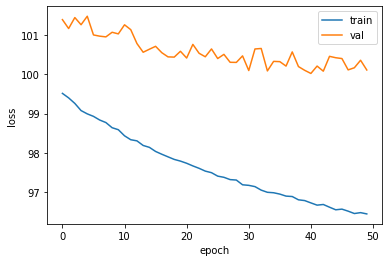

In [21]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [22]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)

        outputs, mu, log_var = best_model(inputs)
        test_loss = loss_func(inputs, outputs, mu, log_var)

        running_loss += test_loss.item()

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)

100.09266959228516


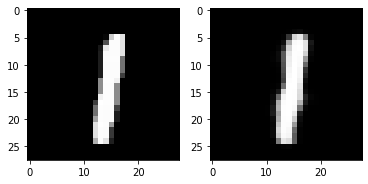

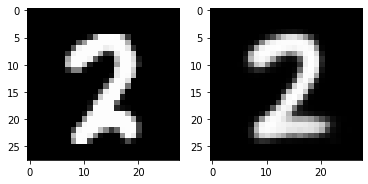

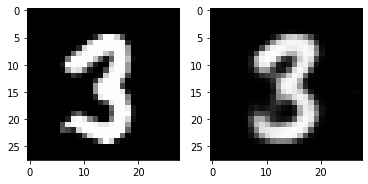

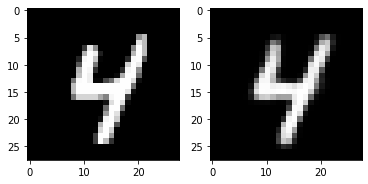

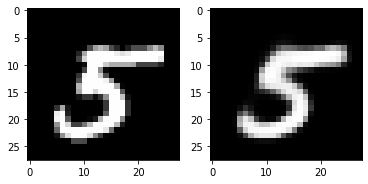

In [23]:
out_img = torch.squeeze(outputs.cpu().data)

for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(out_img[i].numpy().reshape(28, 28), cmap="gray")
    plt.show()

In [24]:
from sklearn.manifold import TSNE

train_dataset_array = mnist_train.dataset.data.numpy() / 255
train_dataset_array = np.float32(train_dataset_array)
labels = mnist_train.dataset.targets.numpy()

subset_indices = []
subset_indices_per_class = []

for i in range(10):
    indices = np.where(labels == i)[0]
    subset_size = len(indices) // 6
    subset_indices += indices[:subset_size].tolist()
    subset_indices_per_class.append(indices[:subset_size].tolist())

train_dataset_array = train_dataset_array[subset_indices]
labels = labels[subset_indices]

In [25]:
train_dataset_array = torch.tensor(train_dataset_array)
inputs = train_dataset_array.to(device)
outputs, mu, log_var = best_model(inputs)

In [26]:
encoded = mu.cpu().detach().numpy()
tsne = TSNE()
X_train_2D = tsne.fit_transform(encoded)
X_train_2D = (X_train_2D - X_train_2D.min()) / (X_train_2D.max() - X_train_2D.min())

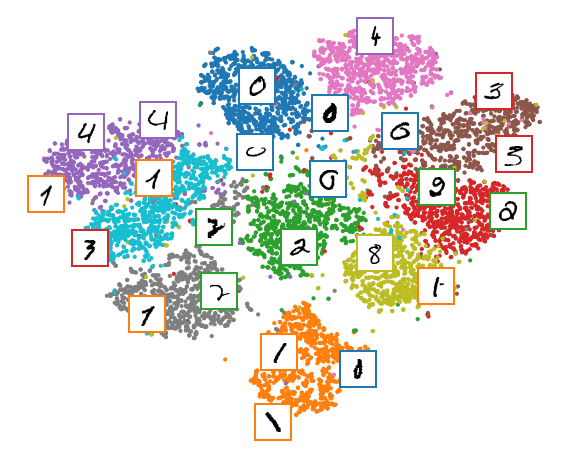

In [27]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1.0, 1.0]])
for index, position in enumerate(X_train_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02:  # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(
                torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"
            ),
            position,
            bboxprops={"edgecolor": cmap(labels[index]), "lw": 2},
        )
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## 5. Save gif result

In [28]:
encoded.shape

(9996, 10)

In [29]:
mean_encoded = []
for i in range(10):
    mean_encoded.append(encoded[np.where(labels == i)[0]].mean(axis=0))

[0 9 5 2 6 4 3 1 8 7]


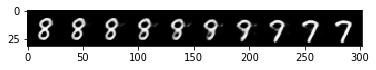

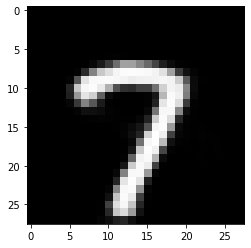

In [30]:
from utils import save_gif

all_numbers = np.arange(10)
np.random.shuffle(all_numbers)
print(all_numbers)

transition = np.empty((0, 28, 28))
for i in range(len(all_numbers) - 1):
    selected_class = [all_numbers[i + 1], all_numbers[i]]
    samples = []
    with torch.no_grad():
        for idx, coef in enumerate(np.linspace(0, 1, 10)):
            interpolated = (
                coef * mean_encoded[selected_class[0]]
                + (1.0 - coef) * mean_encoded[selected_class[1]]
            )
            samples.append(interpolated)
        samples = np.stack(samples)
        z = torch.tensor(samples).to(device)
        generated = best_model.decoder(z).cuda()
        generated = generated.view(10, 1, 28, 28)
        img = make_grid(generated, nrow=10)
        npimg = img.cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
        transition = np.concatenate(
            (transition, torch.squeeze(generated).cpu().numpy()), axis=0
        )

save_gif(transition, "vae1.gif")